# 07. bonniema/salary-predictor

## Model 5: Pre-trained Word2Vec as the Embedding Layer

## Import libraries and the final salary dataset

In [32]:
import time
from time import time
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Deep learning
import tensorflow as tf
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier #to use Keras in sklearn
from keras.initializers import Constant

# Deep Learning - Mixed inputs
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop

%matplotlib inline
np.random.seed(0)

[nltk_data] Downloading package stopwords to C:\Users\Doğan Yiğit
[nltk_data]     Yenigün\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
salary_df = pd.read_csv('salary_final_done.csv')

In [3]:
print(salary_df.shape)
salary_df.drop('Unnamed: 0.2', axis=1, inplace=True)
salary_df.drop('Unnamed: 0.1', axis=1, inplace=True)
salary_df.drop('Unnamed: 0', axis=1, inplace=True)
salary_df.head()

(963, 27)


,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,...,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,combined_text,Salary_Bins
0,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,"2021048 Data Scientist $215,000.00 Position Re...",5
1,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science/Data Analyst Cost Readiness Analy...,1
2,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science Intern Job Title: Data Science In...,0
3,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Jr. Data Scientist Ideal candidate should have...,2
4,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Business Data Quality Engineer Please note tha...,3


In [4]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Title                           963 non-null    object 
 1   Company                         963 non-null    object 
 2   Link                            963 non-null    object 
 3   Review                          963 non-null    object 
 4   Salary                          963 non-null    object 
 5   Description                     963 non-null    object 
 6   Location2                       958 non-null    object 
 7   Rate_by                         963 non-null    object 
 8   low                             963 non-null    object 
 9   high                            762 non-null    object 
 10  min                             963 non-null    float64
 11  max                             963 non-null    float64
 12  adjusted_salary                 963 

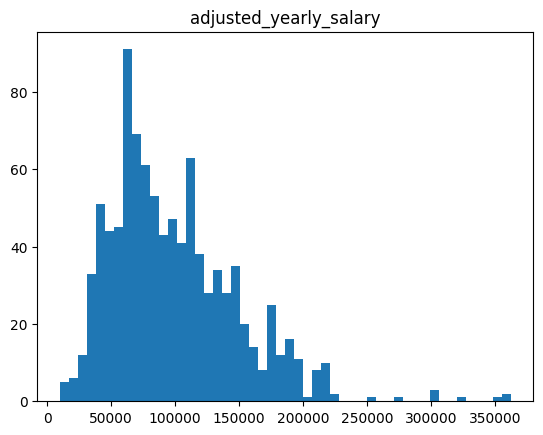

In [5]:
salary_df.hist('adjusted_yearly_salary', bins=50)
plt.grid(axis='both')
plt.show()

In [6]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

In [7]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,7)))

0.000000     10000.000000
0.166667     54026.666667
0.333333     70000.000000
0.500000     90000.000000
0.666667    114400.000000
0.833333    145600.000000
1.000000    362500.000000
Name: adjusted_yearly_salary, dtype: float64

In [8]:
salary_df['Salary_Bins']

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: int64

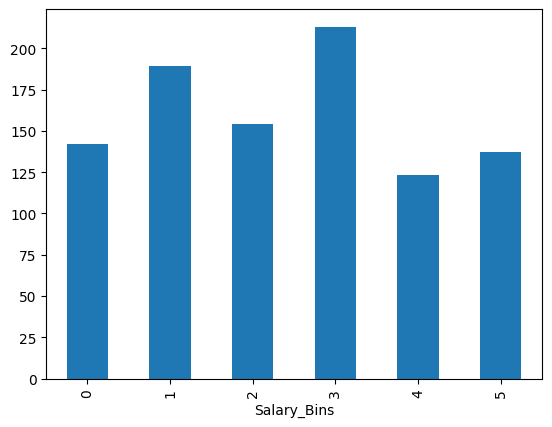

In [9]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()
plt.show()

In [10]:
# Categorical target
target_class = salary_df['Salary_Bins'].astype('category')

In [11]:
target_class

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [12]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','covid','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [13]:
data = clean_word(salary_df['combined_text'])

In [14]:
data

0      [data, scientist, position, requires, top, sec...
1      [data, science, data, analyst, cost, readiness...
2      [data, science, intern, job, title, data, scie...
3      [jr, data, scientist, ideal, candidate, degree...
4      [business, data, quality, engineer, please, no...
                             ...                        
958    [data, engineering, ii, data, engineering, ii,...
959    [ir, day, shift, tier, ir, day, shift, salary,...
960    [security, engineer, security, engineer, salar...
961    [fdp, analyst, position, title, fdp, analyst, ...
962    [junior, ms, access, vba, developer, want, acc...
Length: 963, dtype: object

## Model 5: Pre-trained Word2Vec as the Embedding Layer

In [16]:
# Create a Word2Vec model with 100 dimensions
# vector_size = the number of dimensions of the N-dimensional space and Word2Vec maps the words into
# min_count = min frequency appeared in the corpus
w2v_model1 = Word2Vec(data, vector_size=100, window=5, min_count=3, workers=4)

In [21]:
w2v_model1.train(data,total_examples=w2v_model1.corpus_count, epochs=10)

(2992914, 3458620)

In [23]:
wv = w2v_model1.wv

In [25]:
# Save model to be used in deep learning step
filename = 'jd_embedding_word2vec1.txt'
w2v_model1.wv.save_word2vec_format(filename, binary=False)

In [26]:
# load the word embedding as a directory of words to vectors
import os
embeddings_index = {}
f = open(os.path.join('','jd_embedding_word2vec1.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [27]:
# Get the total_vocabulary in the corpus
total_vocabulary = set(word for jd in data for word in jd)
max_length = len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 13262 unique tokens in the dataset.


In [28]:
# Convert the word embedding into tokenized vector. 
new_tokenizer = text.Tokenizer() 
new_tokenizer.num_words = 1000  # Limit the number of words to keep most common 1000 words
new_tokenizer.fit_on_texts(list(salary_df['combined_text']))
list_tokenized_jd = new_tokenizer.texts_to_sequences(salary_df['combined_text'])

# Pad sequences
word_index = new_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

jd_pad = pad_sequences(list_tokenized_jd, maxlen=500, padding = 'post') 
print('Shape of the jd tensor:', jd_pad.shape)

Found 26519 unique tokens.
Shape of the jd tensor: (963, 500)


In [29]:
# Map embeddings from word2vec model for each word to new_tokenzier.word_index and create a matrix with word vectors
num_words = len(word_index)+1  # 1000  + 1
embedding_matrix = np.zeros((num_words, 100)) # Embedding size = 100
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [30]:
print(num_words)

26520


### Define deep learning model

In [33]:
model = Sequential()
embedding_size = 100  # word2vec has a 100 dimension space
embedding_layer = Embedding(input_dim = num_words, # input_dim: size of the vocabulary
                    output_dim = embedding_size,  # dimension of the dense embedding
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length = 500, #length of input sequences
                    trainable = False)
model.add(embedding_layer)
#model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Flatten())   # add Flatten layer 
model.add(Dense(6, activation='softmax'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          2652000   
                                                                 
 dense (Dense)               (None, 500, 128)          12928     
                                                                 
 dense_1 (Dense)             (None, 500, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense_2 (Dense)             (None, 6)                 96006     
                                                                 
Total params: 2,765,062
Trainable params: 113,062
Non-trainable params: 2,652,000
_________________________________________________________________


In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
# Encoding to categorical classes
y = to_categorical(target_class.values, num_classes=6, dtype="float32")

In [38]:
y

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(jd_pad, y, test_size=0.1, random_state=4)

In [40]:
# Lower the learning rate since it is training too fast. Limit the input length
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=[X_test, y_test])

Epoch 1/10
28/28 [==============================] - 1s 29ms/step - loss: 1.9464 - accuracy: 0.2575 - val_loss: 1.5660 - val_accuracy: 0.3608
Epoch 2/10
28/28 [==============================] - 1s 20ms/step - loss: 0.5734 - accuracy: 0.8995 - val_loss: 1.4886 - val_accuracy: 0.4330
Epoch 3/10
28/28 [==============================] - 1s 19ms/step - loss: 0.1355 - accuracy: 0.9861 - val_loss: 1.5923 - val_accuracy: 0.4536
Epoch 4/10
28/28 [==============================] - 1s 22ms/step - loss: 0.0440 - accuracy: 0.9965 - val_loss: 1.6946 - val_accuracy: 0.4948
Epoch 5/10
28/28 [==============================] - 1s 20ms/step - loss: 0.0246 - accuracy: 0.9977 - val_loss: 1.8996 - val_accuracy: 0.4433
Epoch 6/10
28/28 [==============================] - 1s 21ms/step - loss: 0.0119 - accuracy: 0.9988 - val_loss: 1.8530 - val_accuracy: 0.4845
Epoch 7/10
28/28 [==============================] - 1s 20ms/step - loss: 0.0080 - accuracy: 0.9988 - val_loss: 1.8907 - val_accuracy: 0.4536
Epoch 8/10
28

### Tuning the model

In [41]:
embedding_size = 100  # word2vec has a 100 dimension space
embedding_layer = Embedding(input_dim = num_words, # input_dim: size of the vocabulary
                    output_dim = embedding_size,   # dimension of the dense embedding
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length = 500,  # length of input sequences
                    trainable = False)
sequence_input = Input(shape=(500,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
preds = Dense(6, activation='softmax')(x)

opt = Adam(learning_rate=0.001)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [42]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
7/7 [==============================] - 2s 221ms/step - loss: 2.0734 - accuracy: 0.1836 - val_loss: 1.7889 - val_accuracy: 0.1546
Epoch 2/100
7/7 [==============================] - 1s 168ms/step - loss: 1.7941 - accuracy: 0.1594 - val_loss: 1.7995 - val_accuracy: 0.2062
Epoch 3/100
7/7 [==============================] - 1s 149ms/step - loss: 1.7895 - accuracy: 0.2252 - val_loss: 1.7914 - val_accuracy: 0.2268
Epoch 4/100
7/7 [==============================] - 1s 174ms/step - loss: 1.7900 - accuracy: 0.2229 - val_loss: 1.7910 - val_accuracy: 0.2268
Epoch 5/100
7/7 [==============================] - 1s 157ms/step - loss: 1.7853 - accuracy: 0.2252 - val_loss: 1.7785 - val_accuracy: 0.2062
Epoch 6/100
7/7 [==============================] - 1s 149ms/step - loss: 1.7682 - accuracy: 0.2413 - val_loss: 1.7588 - val_accuracy: 0.2268
Epoch 7/100
7/7 [==============================] - 1s 147ms/step - loss: 1.7378 - accuracy: 0.2413 - val_loss: 1.7517 - val_accuracy: 0.2268
Epoch 8/100
7

Epoch 59/100
7/7 [==============================] - 1s 176ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 6.3924 - val_accuracy: 0.3814
Epoch 60/100
7/7 [==============================] - 1s 159ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 6.4645 - val_accuracy: 0.3814
Epoch 61/100
7/7 [==============================] - 1s 161ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 6.5120 - val_accuracy: 0.3814
Epoch 62/100
7/7 [==============================] - 1s 156ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 6.5810 - val_accuracy: 0.3814
Epoch 63/100
7/7 [==============================] - 1s 163ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 6.6346 - val_accuracy: 0.3814
Epoch 64/100
7/7 [==============================] - 1s 163ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 6.7054 - val_accuracy: 0.3814
Epoch 65/100
7/7 [==============================] - 1s 158ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 6.7643 - val_accuracy: 0.3814
Epoch 

This result shows that the model becomes overfit and test accuracy is fixed at 38% and the loss is very high!

### Grid Search

In [44]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(learn_rate=0.1):
    # Create model
    embedding_size = 100  # word2vec has a 100 dimension space
    embedding_layer = Embedding(input_dim = num_words, # input_dim: size of the vocabulary
                    output_dim = embedding_size,       # dimension of the dense embedding
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length = 500,    # length of input sequences
                    trainable = False)

    sequence_input = Input(shape=(500,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 10, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(6, activation='softmax')(x)
    
    opt=Adam(learning_rate=learn_rate)
    model = Model(sequence_input, preds)
    
    #Compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=20, batch_size=50)

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Temp\ipykernel_17836\1778992493.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0, epochs=20, batch_size=50)


In [45]:
param_grid = {'learn_rate':[0.001,0.005,0.01,0.05]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.431881 using {'learn_rate': 0.001}
0.431881 (0.009550) with: {'learn_rate': 0.001}
0.378785 (0.028743) with: {'learn_rate': 0.005}
0.342981 (0.016287) with: {'learn_rate': 0.01}
0.228654 (0.019775) with: {'learn_rate': 0.05}


### Try CountVectorizer and TF-IDF in Deep Learning Models with Grid Search

In [47]:
text = salary_df['combined_text']

In [48]:
count_vectorizer = CountVectorizer(max_features = 300, max_df = 0.5, min_df = 0.03, ngram_range=(1,3), stop_words='english')
word_count_vector = count_vectorizer.fit_transform(text)

In [51]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [52]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vectorizer.get_feature_names(), columns=['idf_weights'])

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
df_idf

,idf_weights
00 hour,2.468414
00 year,2.053980
000,1.718359
000 00,2.102770
000 00 year,2.147506
...,...
year preferred,3.126159
years experience,2.280104
years preferred,2.753097
years required,2.656156


In [56]:
tfidf_mat = tfidf_transformer.transform(word_count_vector)

In [57]:
type(tfidf_mat)

scipy.sparse._csr.csr_matrix

In [58]:
# Each job description has 300 features, each feature is one word
tfidf_mat

<963x300 sparse matrix of type '<class 'numpy.float64'>'
	with 73819 stored elements in Compressed Sparse Row format>

In [75]:
tfidf_mat.toarray()

array([[0.        , 0.02904836, 0.34022575, ..., 0.        , 0.        ,
        0.37562398],
       [0.        , 0.06373466, 0.05332038, ..., 0.08542815, 0.        ,
        0.        ],
       [0.04120745, 0.        , 0.0286861 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [59]:
# Encoding to categorical classes
y = to_categorical(target_class.values, num_classes=6, dtype="float32")

In [91]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_mat, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(770, 300) (193, 300)


In [95]:
X_train.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10009615],
       [0.        , 0.05181733, 0.0867007 , ..., 0.        , 0.        ,
        0.07444992],
       [0.        , 0.05501234, 0.18409318, ..., 0.        , 0.14228117,
        0.        ],
       ...,
       [0.        , 0.05828828, 0.04876394, ..., 0.23438392, 0.        ,
        0.        ],
       [0.1523592 , 0.        , 0.        , ..., 0.16993087, 0.        ,
        0.        ],
       [0.        , 0.03689705, 0.0617361 , ..., 0.04945577, 0.        ,
        0.        ]])

In [100]:
X_test.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.17881404],
       [0.15546513, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03705615, 0.09300347, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10898443],
       [0.10246622, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07203407, ..., 0.        , 0.        ,
        0.        ]])

In [63]:
model = Sequential()
model.add(Dense(100, input_shape=(300,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# model.add(Flatten())   # add Flatten layer 
model.add(Dense(6, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.001)
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               30100     
                                                                 
 dense_9 (Dense)             (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 6)                 390       
                                                                 
Total params: 36,954
Trainable params: 36,954
Non-trainable params: 0
_________________________________________________________________


In [99]:
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
# This can give InvalidArgumentError in the current setting, advises using 'tf.sparse.reorder' and SparseTensor
history = model.fit(X_train_arr, y_train, validation_data=(X_test_arr, y_test), epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
13/13 [==============================] - 0s 13ms/step - loss: 1.7815 - accuracy: 0.2104 - val_loss: 1.7702 - val_accuracy: 0.1865
Epoch 2/40
13/13 [==============================] - 0s 5ms/step - loss: 1.7489 - accuracy: 0.2805 - val_loss: 1.7523 - val_accuracy: 0.1813
Epoch 3/40
13/13 [==============================] - 0s 4ms/step - loss: 1.7224 - accuracy: 0.2831 - val_loss: 1.7244 - val_accuracy: 0.2539
Epoch 4/40
13/13 [==============================] - 0s 4ms/step - loss: 1.6900 - accuracy: 0.3429 - val_loss: 1.6932 - val_accuracy: 0.3316
Epoch 5/40
13/13 [==============================] - 0s 4ms/step - loss: 1.6488 - accuracy: 0.3649 - val_loss: 1.6551 - val_accuracy: 0.3472
Epoch 6/40
13/13 [==============================] - 0s 4ms/step - loss: 1.5899 - accuracy: 0.3779 - val_loss: 1.6202 - val_accuracy: 0.3782
Epoch 7/40
13/13 [==============================] - 0s 4ms/step - loss: 1.5398 - accuracy: 0.4156 - val_loss: 1.5751 - val_accuracy: 0.3938
Epoch 8/40
13/13 [=

Train: 0.901, Test: 0.528


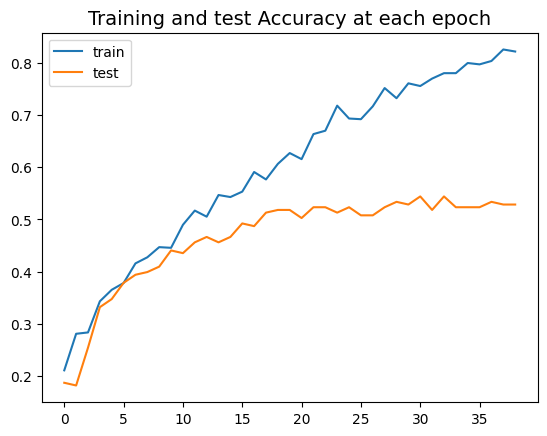

In [102]:
# Evaluate the model
_, train_acc = model.evaluate(X_train_arr, y_train, verbose=0)
_, test_acc = model.evaluate(X_test_arr, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# Plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Training and test Accuracy at each epoch', fontsize=14)
plt.legend()
plt.show()

### Grid Search

In [103]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(neurons=1):
    # Create model
    model = Sequential()
    model.add(Dense(neurons, input_shape=(300,), activation='relu'))
    model.add(Dense(16, activation='relu'))
    # model.add(Flatten())   # add Flatten layer 
    model.add(Dense(6, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=20, batch_size=50)

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Temp\ipykernel_17836\1454629559.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0, epochs=20, batch_size=50)


In [105]:
# Define the grid search parameters
# learning_rate = [0.001,0.0001]
param_grid = {'neurons':[32,64,128,256]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_arr, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.442794 using {'neurons': 256}
0.427225 (0.026315) with: {'neurons': 32}
0.435012 (0.029321) with: {'neurons': 64}
0.433715 (0.028114) with: {'neurons': 128}
0.442794 (0.034275) with: {'neurons': 256}
